In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os import listdir

%matplotlib inline
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

from os import listdir

from tqdm.notebook import tqdm

# Load data

In [7]:
DATA_DIR = join("private", "Carbs2_data_RL")

## Behavioural data

In [16]:
listdir(DATA_DIR)[:2]

['temp_acquisition_RL_05_session02_2_21032017_1217.mat',
 'temp_acquisition_RL_03_session01_2_03032017_1220.mat']

In [17]:
file = join(DATA_DIR, "temp_acquisition_RL_05_session02_2_21032017_1217.mat")

In [18]:
x = loadmat(file)

In [22]:
pd.DataFrame(x['data_matrix'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,1.0,1.0,0.0,1.0,98.0,0.0,1.0,13908.776335,13908.776468,0.009624,0.522540,0.543223,1.559783,2.0
1,2.0,1.0,2.0,1.0,1.0,99.0,0.0,0.0,13908.776335,13908.776468,3.593000,0.432014,4.043072,5.059572,2.0
2,3.0,1.0,3.0,0.0,1.0,98.0,0.0,1.0,13908.776335,13908.776468,7.092740,0.397094,7.509472,8.526039,8.0
3,4.0,1.0,4.0,1.0,1.0,99.0,0.0,0.0,13908.776335,13908.776468,16.558749,0.411769,16.992201,18.008788,2.0
4,5.0,1.0,5.0,1.0,1.0,98.0,1.0,1.0,13908.776335,13908.776468,20.041900,0.441531,20.491976,21.508536,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96.0,7.0,9.0,1.0,1.0,98.0,1.0,1.0,13908.776335,13908.776468,517.428406,0.472070,517.911689,518.928312,2.0
96,97.0,7.0,10.0,1.0,1.0,98.0,1.0,1.0,13908.776335,13908.776468,520.961347,0.430959,521.411393,522.428037,6.0
97,98.0,8.0,1.0,0.0,1.0,98.0,0.0,3.0,13908.776335,13908.776468,528.461019,0.511060,528.994307,530.010949,8.0
98,99.0,8.0,2.0,0.0,1.0,98.0,0.0,3.0,13908.776335,13908.776468,538.043757,0.432069,538.493749,539.510389,8.0


In [12]:
def read_behavioural_data2(data_dir):
    """This function reads, processes and combines all .mat files
    containing behavioural data from the prior experiment (`Carbs2_data_RL` folder)
    run in Soyoung's Lab and transforms them into a single pandas.DataFrame.
    
    Args:
        data_dir (str): Path to the data directory.
    
    Returns:
        pandas.DataFrame: Formatted data.
    """

    columns = [
        "trial",  # 1-100
        "state",  # type reversal block 1, 2, 3 || FM: I think there's an error and this variable counts the number of reversals
        "trial_s",  # trial count in reversal block 1 to min 10 and max 16, 70% min accuracy for reversal
        "correct_response",  # 1 left side correct, 0 right side correct
        "_",  # response recorded: 1 button was pressed, 0 no button was pressed
        "a",  # pressed button 98 leftkey, 99 rightkey || FM: I think there's also 0s in this column, if no response was made?
        "r",  # feedback: 1 smiley, 0 frowny
        "correct",  # resposne correct: 1 yes, 0 no, 3 if both options were correct (50:50 states)
        "_",  # timestamp "scan0"
        "_",  # timestamp "exp0"
        "_",  # timestamp "stimulus onset"
        "rt",  # response time
        "_",  # timestamp "feedback onset"
        "_",  # timestamp "fixation onset"
        "_",  # intertrial interval
    ]

    df = []

    for condition in conditions:
        # List all mat files
        matfiles = [
            file
            for file in listdir(join(data_dir, condition))
            if file.endswith(".mat")
        ]

        for filename in matfiles:
            # Extract subject ID
            # (filenames look like this: "temp_acquisition_RL_05_session02_2_21032017_1217.mat")
            subject = int(filename[20:22])
            session = int(filename[30:32])
            block = int(filename[33:34]) - 1

            # Load data of single subject and condition
            x = loadmat(join(data_dir, condition, filename))
            df_sc = pd.DataFrame(x["data_matrix"], columns=columns)
            df_sc["condition"] = condition.lower()
            df_sc["subject"] = subject
            df_sc["session"] = session
            df_sc["block"] = block

            # Append to list of all dataframes
            df.append(df_sc)

    # Concatenate all dataframes
    df = pd.concat(df)

    # Reformat variables
    df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
    df["a"] = (df["a"] - 98).astype(
        np.int32
    )  # Recode from 98 = left 99 = right to 0 = left, 1 = right
    df.loc[df["a"] == -98, "a"] = np.nan
    df["s"] = 0
    df["state"] = df["state"].astype(np.int32)

    return (
        df[
            [
                "subject",
                "block",
                "trial",
                "state",
                "s",
                "a",
                "r",
                "session",
                "condition",
            ]
        ]
        .sort_values(["condition", "subject", "block", "trial"])
        .reset_index(drop=True)
    )

In [11]:
def read_behavioural_data(data_dir, conditions=["HighCarb", "HighPro"]):
    """This function reads, processes and combines all .mat files
    containing behavioural data from the prior experiment run in Soyoung's Lab
    and transforms them into a single pandas.DataFrame.
    
    Args:
        data_dir (str): Path to the data directory with folders for data from each condition.
        conditions (list): List of condition names. These must match the name of the folders in `data_dir`
    
    Returns:
        pandas.DataFrame: Formatted data.
    """

    columns = [
        "trial",  # 1-100
        "state",  # type reversal block 1, 2, 3 || FM: I think there's an error and this variable counts the number of reversals
        "trial_s",  # trial count in reversal block 1 to min 10 and max 16, 70% min accuracy for reversal
        "correct_response",  # 1 left side correct, 0 right side correct
        "_",  # response recorded: 1 button was pressed, 0 no button was pressed
        "a",  # pressed button 98 leftkey, 99 rightkey || FM: I think there's also 0s in this column, if no response was made?
        "r",  # feedback: 1 smiley, 0 frowny
        "correct",  # resposne correct: 1 yes, 0 no, 3 if both options were correct (50:50 states)
        "_",  # timestamp "scan0"
        "_",  # timestamp "exp0"
        "_",  # timestamp "stimulus onset"
        "rt",  # response time
        "_",  # timestamp "feedback onset"
        "_",  # timestamp "fixation onset"
        "_",  # intertrial interval
    ]

    df = []

    for condition in conditions:
        # List all mat files
        matfiles = [
            file
            for file in listdir(join(data_dir, condition))
            if file.endswith(".mat")
        ]

        for filename in matfiles:
            # Extract subject ID
            # (filenames look like this: "temp_acquisition_RL_05_session02_2_21032017_1217.mat")
            subject = int(filename[20:22])
            session = int(filename[30:32])
            block = int(filename[33:34]) - 1

            # Load data of single subject and condition
            x = loadmat(join(data_dir, condition, filename))
            df_sc = pd.DataFrame(x["data_matrix"], columns=columns)
            df_sc["condition"] = condition.lower()
            df_sc["subject"] = subject
            df_sc["session"] = session
            df_sc["block"] = block

            # Append to list of all dataframes
            df.append(df_sc)

    # Concatenate all dataframes
    df = pd.concat(df)

    # Reformat variables
    df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
    df["a"] = (df["a"] - 98).astype(
        np.int32
    )  # Recode from 98 = left 99 = right to 0 = left, 1 = right
    df.loc[df["a"] == -98, "a"] = np.nan
    df["s"] = 0
    df["state"] = df["state"].astype(np.int32)

    return (
        df[
            [
                "subject",
                "block",
                "trial",
                "state",
                "s",
                "a",
                "r",
                "session",
                "condition",
            ]
        ]
        .sort_values(["condition", "subject", "block", "trial"])
        .reset_index(drop=True)
    )

In [10]:
bh = read_behavioural_data(join(DATA_DIR, "Behav"), conditions=["HighCarb", "HighPro"])
bh.head()

FileNotFoundError: [Errno 2] No such file or directory: 'private/Carbs2_data_RL/Behav/HighCarb'

In [8]:
len(bh)

7800

This should be 8000 (20 subjects * 2 conditions * 2 blocks * 100 trials).

In [9]:
bh["subject"].value_counts().sort_values()[:5]

13    200
11    400
7     400
3     400
18    400
Name: subject, dtype: int64

In [10]:
bh.loc[bh["subject"] == 13, "condition"].unique()

array(['highpro'], dtype=object)

Subject 13 is missing in `HighCarb` condition.

### Visualize some data

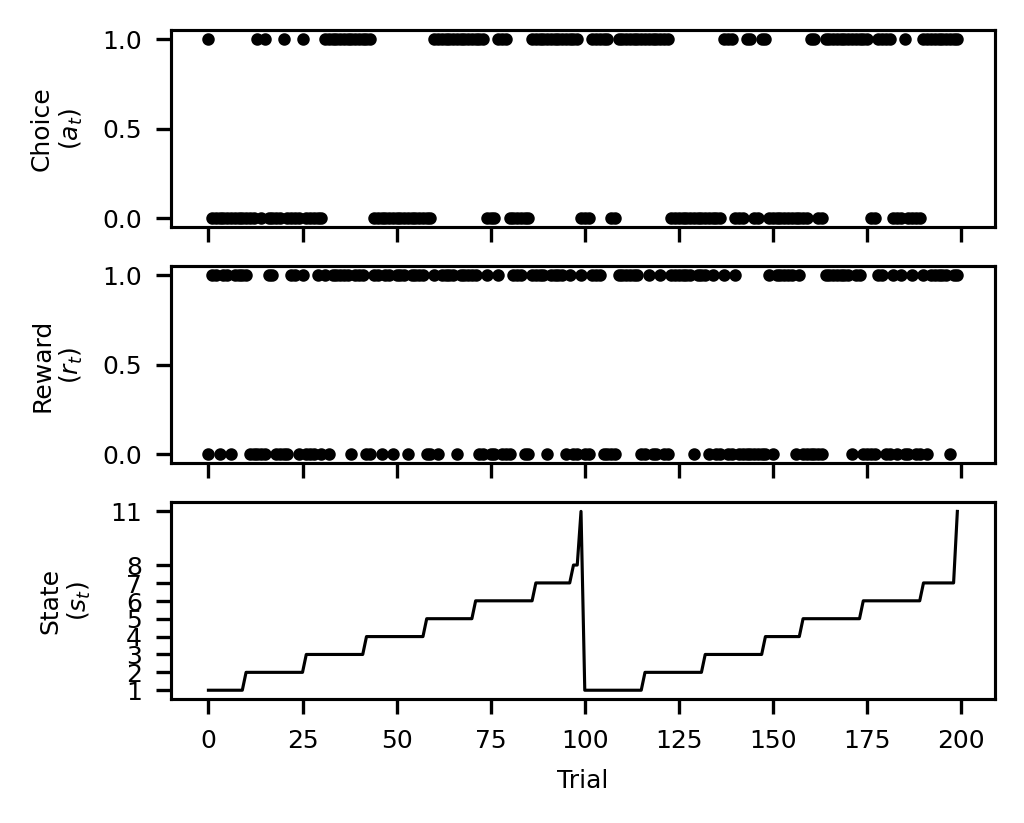

In [11]:
data = (bh.loc[(bh["subject"] == 1) & (bh["condition"] == "highcarb")]).reset_index(
    drop=True
)
rl.plots.plot_data(data);

Looks like the state variable (Column 2 in the original data set) is something else. Maybe an count of the number of reversals? Still, numbers 9 and 10 are missing from it. Not sure. This is not important for fitting, if the other variables are coded correctly, though, because the agent only assumes one state anyway in the task.

In [12]:
bh["a"].isnull().groupby(bh["subject"]).sum()

subject
1      1
2     13
3      0
4     93
5      0
6      0
7      6
8      1
9      1
10     1
11     1
12     0
13     3
14    13
15     6
16     1
17    17
18     3
19     0
20     3
Name: a, dtype: int64

There are some subjects with a considerable number of trials without response (e.g., subject 4 misses 93 trials in total!).

## Physiological data

In [13]:
def read_physiological_data(phys_data_file):
    """This function reads and processes the
    physiological data from wide Excel .xlsx
    to a long pandas.DataFrame
    
    Args:
        phys_data_file (str): Path to the Excel file containing physiological data.
        
    Returns:
        pandas.DataFrame: Long pandas.DataFrame
    """

    ph = pd.read_excel(phys_data_file)

    ph.rename(
        {
            "Sub_ID": "subject",
            "AUC_Tyr_HighCarb": "tyr-highcarb",
            "AUC_Tyr_HighPro": "tyr-highpro",
            "AUC_Trp_HighCarb": "trp-highcarb",
            "AUC_Trp_HighPro": "trp-highpro",
        },
        axis=1,
        inplace=True,
    )
    ph["subject"] = ph["subject"].apply(lambda x: int(x[1:]))

    ph = (
        pd.wide_to_long(
            ph,
            stubnames=["tyr", "trp"],
            i="subject",
            j="condition",
            sep="-",
            suffix="\\w+",
        )
        .sort_values(["subject", "condition"])
        .reset_index()
    )
    return ph

In [14]:
ph = read_physiological_data(join(DATA_DIR, "Blood.xlsx"))
ph.head()

,subject,condition,tyr,trp
0,1,highcarb,0.518,0.688
1,1,highpro,0.487,0.529
2,2,highcarb,0.635,0.838
3,2,highpro,0.593,0.658
4,3,highcarb,0.587,0.823


# Visualize data

In [15]:
import seaborn as sns
from scipy.stats import sem

In [16]:
ph_desc = ph.groupby("condition")[["tyr", "trp"]].agg([np.mean, sem])
ph_desc

tyr               trp          
              mean       sem    mean       sem
condition                                     
highcarb   0.59635  0.017623  0.6984  0.021702
highpro    0.63985  0.020172  0.5806  0.020744

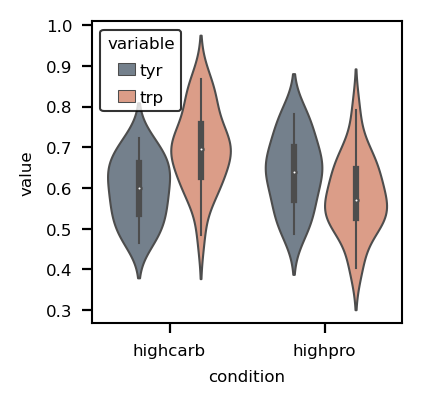

In [17]:
ph_longer = ph.melt(id_vars=["subject", "condition"], value_vars=["tyr", "trp"])
fig, ax = plt.subplots(figsize=(2, 2), dpi=200)
ax = sns.violinplot(
    x="condition", y="value", hue="variable", data=ph_longer, kind="violin", ax=ax
)

Check out differences between conditions

In [18]:
from scipy.stats import ttest_rel

In [19]:
ph_wide = ph.pivot(index="subject", columns="condition")

In [20]:
for var in ["tyr", "trp"]:
    diff = ph_wide[var]["highcarb"] - ph_wide[var]["highpro"]
    ph_wide[(var, "diff")] = diff
ph_wide.head()

tyr              trp            tyr    trp
condition highcarb highpro highcarb highpro   diff   diff
subject                                                  
1            0.518   0.487    0.688   0.529  0.031  0.159
2            0.635   0.593    0.838   0.658  0.042  0.180
3            0.587   0.619    0.823   0.791 -0.032  0.032
4            0.572   0.632    0.603   0.531 -0.060  0.072
5            0.519   0.509    0.696   0.516  0.010  0.180

In [21]:
for var in ["tyr", "trp"]:
    print(f"Measure: {var}")
    t, p = ttest_rel(ph_wide[(var, "highcarb")], ph_wide[(var, "highpro")])
    print(f"  High-Carb vs. High-Pro, paired t-test: t = {t:.2f}, p = {p:.2f}")

Measure: tyr
  High-Carb vs. High-Pro, paired t-test: t = -2.38, p = 0.03
Measure: trp
  High-Carb vs. High-Pro, paired t-test: t = 5.89, p = 0.00


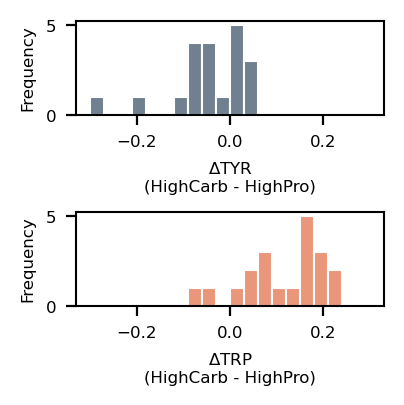

In [22]:
bins = np.linspace(-0.3, 0.3, 21)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(2, 2), dpi=200)
for i, var in enumerate(["tyr", "trp"]):
    axs[i].hist(ph_wide[(var, "diff")], bins=bins, color=f"C{i}", edgecolor="white")
    axs[i].set_xlabel("$\Delta$" + var.upper() + "\n(HighCarb - HighPro)")
    axs[i].set_ylabel("Frequency")
    axs[i].xaxis.set_tick_params(which="both", labelbottom=True)
fig.tight_layout()

- Tyrosene is higher in `HighPro` condition / lower in `HighCarb` condition
- Tryptophane is higher in `HighCarb` / lower in `HighPro`

# Fit reinforcement learning model

In [23]:
task_vars = rl.task.TaskVars(n_trials=100, n_blocks=2, n_options=2, n_states=1)

In [32]:
# Initialize estimation variables

# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0.01, 20)}

# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=5,
)

# Initialize estimation instance
est = rl.estimation.Estimation(est_vars)

## Fit `HighCarb` and `HighPro` conditions separately

In [34]:
from os.path import exists

In [35]:
ESTIMATES_FILE = "parklab_RWpn-estimates.csv"

# skip estimation and read results, if they are already present:
if exists(ESTIMATES_FILE):
    print(f"Read existing estimates from '{ESTIMATES_FILE}'.")
    estimates = pd.read_csv(ESTIMATES_FILE, index_col=0)
else:
    # Initialize agent_vars
    agent_vars = rl.agent.AgentVars(variant="r")

    estimates = {}

    # Cycle over conditions
    conditions = ["highcarb", "highpro"]
    for condition in conditions:
        print(f"Estimating parameters for '{condition}' condition.")

        estimates[condition] = []

        # Cycle over subjects with data in that condition
        for subject in tqdm(bh.loc[bh["condition"] == condition, "subject"].unique()):
            print(f"  Subject {subject}")

            # Subject DataFrame
            df_s = bh.loc[(bh["subject"] == subject) & (bh["condition"] == condition)]

            # Now we can estimate the maximum likelihood parameters
            estimates_s = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

            # Save results to DataFrame
            estimates_df = pd.DataFrame(
                dict(
                    subject=subject,
                    nll=estimates_s[0],
                    bic=estimates_s[1],
                    alpha_pos=estimates_s[2][0],
                    alpha_neg=estimates_s[2][1],
                    beta=estimates_s[2][2],
                ),
                index=[subject],
            )
            estimates[condition].append(estimates_df)

        # Concatenate results for this condition, across subjects
        estimates[condition] = (
            pd.concat(estimates[condition])
            .sort_values("subject")
            .reset_index(drop=True)
        )
        estimates[condition]["condition"] = condition

    # Concatenate results across conditions
    estimates = pd.concat(
        [estimates[condition] for condition in conditions]
    ).reset_index(drop=True)
    estimates.to_csv(ESTIMATES_FILE)

Estimating parameters for 'highcarb' condition.


  Subject 1
  Subject 2
  Subject 3
  Subject 4
  Subject 5
  Subject 6
  Subject 7
  Subject 8
  Subject 9
  Subject 10
  Subject 11
  Subject 12
  Subject 14
  Subject 15
  Subject 16
  Subject 17
  Subject 18
  Subject 19
  Subject 20

Estimating parameters for 'highpro' condition.


  Subject 1
  Subject 2
  Subject 3
  Subject 4
  Subject 5
  Subject 6
  Subject 7
  Subject 8
  Subject 9
  Subject 10
  Subject 11
  Subject 12
  Subject 13
  Subject 14
  Subject 15
  Subject 16
  Subject 17
  Subject 18
  Subject 19
  Subject 20



In [36]:
estimates.head()

,subject,nll,bic,alpha_pos,alpha_neg,beta,condition
0,1,58.401654,132.698260,0.127049,0.662515,20.000000,highcarb
1,2,49.851021,115.596995,0.341985,0.882512,20.000000,highcarb
2,3,55.780248,127.455447,0.419143,0.749337,9.396773,highcarb
3,4,85.370383,186.635718,1.000000,0.967888,0.654255,highcarb
4,5,34.126652,84.148257,1.000000,0.846418,20.000000,highcarb


## Visualize model fit for some participants

# Parameter recovery of the estimated parameters with the task used

In [37]:
# %% 1.1 Set up Reversal-Learning-Task (rv) as in Kahnt, Park et al. (2008)
# -------------------------------------------------------------------------
print("1.1 Set up Reversal-Learning-Task (rv) as in Kahnt, Park et al. (2008)")
print("----------------------------------------------------------------------")

# Set up the three different states
rv_states = {
    # 20:80
    0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [1, 0]},
    # 80:20
    1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [1, 0]},
    # 50:50
    2: {"p_r": [0.5, 0.5], "a_correct": [0, 1], "rewards": [1, 0]},
}
rv_task_vars = rl.task.TaskVars(
    n_trials=100,
    n_blocks=2,
    n_options=2,
    states=rv_states,
    n_trials_reversal_min=10,  # minimum number of trials before reversal
    n_trials_reversal_max=16,  # maximum number of trials without reversal
    p_correct_reversal_min=0.7,  # minimum accuracy before reversal before `n_trials_reversal_max`
)

rv_task = rl.task.ReversalLearningTask(task_vars=rv_task_vars)
print(rv_task)

1.1 Set up Reversal-Learning-Task (rv) as in Kahnt, Park et al. (2008)
----------------------------------------------------------------------
Reversal learning task with the states (rules):
  {0: {'p_r': [0.2, 0.8], 'a_correct': [1], 'rewards': [1, 0]}, 1: {'p_r': [0.8, 0.2], 'a_correct': [0], 'rewards': [1, 0]}, 2: {'p_r': [0.5, 0.5], 'a_correct': [0, 1], 'rewards': [1, 0]}}


In [38]:
# %% 2. Set up Dual-Learning-Rate Agent
# -------------------------------------
print("2. Set up Dual-Learning-Rate Agent")
print("----------------------------------")


# Use mean parameters from Lefebvre et al. (2017) just for initialization
agent_vars = rl.agent.AgentVars(
    alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13), variant="r"
)
agent = rl.agent.DualLearningRateAgent(
    agent_vars=agent_vars, n_options=rv_task.task_vars.n_options, n_states=1
)
print(agent)

2. Set up Dual-Learning-Rate Agent
----------------------------------
Dual learning rate agent (r variant) with
  alpha_pos = 0.36
  alpha_neg = 0.22
  beta = 7.69


In [39]:
# %% 3. Set up Estimation
# -----------------------
print("3. Set up estimation")
print("--------------------")

# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)}

# Initialize estimation variables and estimation instance
# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    rv_task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=5,
)
est = rl.estimation.Estimation(est_vars)
est

3. Set up estimation
--------------------


In [40]:
# %% 4. Run parameter recovery of obtained parameter estimates
# ------------------------------------------------------------
print("4. Run recovery of obtained estimates")
print("-------------------------------------")

RECOVERY_FILE = "parklab_RWpn-recovery.csv"

# skip estimation and read results, if they are already present:
if exists(RECOVERY_FILE):
    print(f"Read existing recovery results from '{RECOVERY_FILE}'.")
    recovery_results = pd.read_csv(RECOVERY_FILE, index_col=0)
else:
    recovery_results = []
    for condition in ["highcarb", "highpro"]:
        print(f"  '{condition}' condition")
        estimates_condition = estimates.loc[estimates["condition"] == condition]
        parameter_values_condition = {
            parameter: estimates_condition[parameter].values
            for parameter in ["alpha_pos", "alpha_neg", "beta"]
        }

        recovery_results_condition = rl.recovery.run_estimate_recovery(
            task=rv_task,
            agent=agent,
            est=est,
            parameter_values=parameter_values_condition,
        )
        recovery_results_condition["condition"] = condition
        recovery_results.append(recovery_results_condition)
    recovery_results = pd.concat(recovery_results).reset_index(drop=True)
    recovery_results.to_csv(RECOVERY_FILE)

4. Run recovery of obtained estimates
-------------------------------------
  'highcarb' condition



  'highpro' condition


## Check parameter recovery results

In [41]:
recovery_results.head()

,idx,n_trials,n_blocks,n_sp,nll,bic,alpha_pos,alpha_pos_hat,alpha_neg,alpha_neg_hat,beta,beta_hat,condition
0,0,100,2,5,72.195654,160.286260,0.127049,0.310032,0.662515,0.489731,20.000000,6.706847,highcarb
1,1,100,2,5,51.641769,119.178489,0.341985,1.000000,0.882512,0.924102,20.000000,20.000000,highcarb
2,2,100,2,5,59.276103,134.447158,0.419143,0.944338,0.749337,0.830272,9.396773,6.079408,highcarb
3,3,100,2,5,127.102092,270.099135,1.000000,0.597456,0.967888,1.000000,0.654255,1.053416,highcarb
4,4,100,2,5,59.221034,134.337020,1.000000,1.000000,0.846418,0.649559,20.000000,4.502699,highcarb


In [42]:
def plot_estimate_recovery(recovery_results, parameters, parameter_limits):
    n_params = len(parameters)
    fig, axs = plt.subplots(1, n_params, figsize=(n_params * 2, 2), dpi=200)

    for i, parameter in enumerate(parameters):
        ax = axs[i]

        # Scatter plot
        x = recovery_results[parameter].values
        y = recovery_results[f"{parameter}_hat"].values
        ax.plot(x, y, "o", markeredgewidth=0.3)

        # Run linear regression
        b, a, r, p, _ = linregress(x=x, y=y)

        if p < 0.05:
            pstr = "*"
        elif p < 0.01:
            pstr = "**"
        elif p < 0.001:
            pstr = "***"
        else:
            pstr = ", n.s."

        # Print linear regression results
        print(
            f"{parameter}_hat ~ {parameter}\n  b={b:.2f}, a={a:.2f}, r={r:.2f}, p={p:.2f}{pstr}\n"
        )

        # Plot regression line
        xs = np.linspace(x.min(), x.max(), 100)
        ax.plot(xs, a + b * xs, color="black")

        # Plot diagonal
        ax.plot(
            parameter_limits[parameter],
            parameter_limits[parameter],
            color="lightgray",
            zorder=-1,
        )

        # Set limits
        ax.set_xlim(parameter_limits[parameter])
        ax.set_ylim(parameter_limits[parameter])

        # Add annotation with linear regression results
        ax.annotate(
            f"b={b:.2f}, a={a:.2f}\nr={r:.2f}, p={p:.2f}",
            (0.95, 0.05),
            ha="right",
            va="bottom",
            xycoords="axes fraction",
            fontsize="xx-small",
        )

        # Labels
        ax.set_title(parameter)
        ax.set_xlabel("Generating")
        ax.set_ylabel("Recovered")

    fig.tight_layout()

    return fig, axs

In [43]:
from scipy.stats import linregress

'highcarb' condition
--------------------
alpha_pos_hat ~ alpha_pos
  b=0.42, a=0.57, r=0.61, p=0.01*

alpha_neg_hat ~ alpha_neg
  b=0.80, a=0.14, r=0.67, p=0.00*

beta_hat ~ beta
  b=0.44, a=1.32, r=0.71, p=0.00*

'highpro' condition
--------------------
alpha_pos_hat ~ alpha_pos
  b=0.16, a=0.67, r=0.18, p=0.44, n.s.

alpha_neg_hat ~ alpha_neg
  b=0.60, a=0.25, r=0.60, p=0.00*

beta_hat ~ beta
  b=0.35, a=2.72, r=0.54, p=0.01*



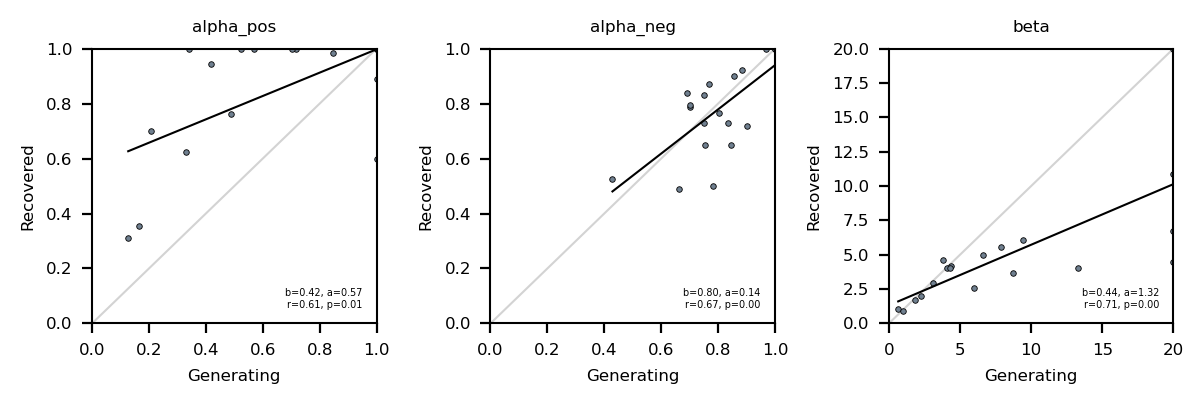

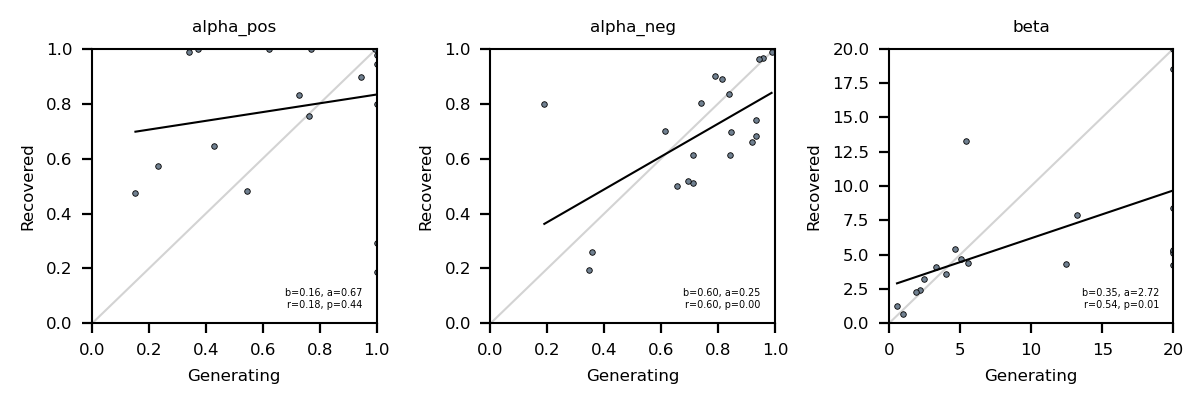

In [45]:
for condition in ["highcarb", "highpro"]:
    print(f"'{condition}' condition\n--------------------")
    fig, axs = plot_estimate_recovery(
        recovery_results.loc[recovery_results["condition"] == condition],
        parameters=["alpha_pos", "alpha_neg", "beta"],
        parameter_limits=dict(alpha_pos=[0, 1], alpha_neg=[0, 1], beta=[0, 20],),
    )

# Perform analyses on parameter estimates and physiological measures

In [47]:
# join DataFrames
df = (
    estimates.merge(ph, on=["subject", "condition"], how="outer")
    .sort_values(["subject", "condition"])
    .reset_index(drop=True)[
        [
            "subject",
            "condition",
            "tyr",
            "trp",
            "nll",
            "bic",
            "alpha_pos",
            "alpha_neg",
            "beta",
        ]
    ]
)
df.head()

,subject,condition,tyr,trp,nll,bic,alpha_pos,alpha_neg,beta
0,1,highcarb,0.518,0.688,58.401654,132.698260,0.127049,0.662515,20.000000
1,1,highpro,0.487,0.529,47.103290,110.101532,0.341133,0.712781,12.456661
2,2,highcarb,0.635,0.838,49.851021,115.596995,0.341985,0.882512,20.000000
3,2,highpro,0.593,0.658,87.969162,191.833276,1.000000,0.693462,2.489275
4,3,highcarb,0.587,0.823,55.780248,127.455447,0.419143,0.749337,9.396773


## Correlation of parameters and physiological measures across conditions

In [48]:
from scipy.stats import linregress

In [49]:
def pairplot(df):
    """This function makes a plot of all pairs
    of variables in the dataframe and runs simple
    linear regressions.
    
    Args:
        df (pandas.DataFrame): A dataframe with all variables of interest.
    
    Returns:
        matplotlib.figure, numpy.array of matplotlib.axes
    """
    # Count variables
    vars = df.columns
    nVars = len(vars)

    # Make a figure with some axes
    fig, axs = plt.subplots(
        nVars, nVars, figsize=(nVars, 4 / 5 * nVars), dpi=200, sharex="col",
    )

    # Cycle over all variables across rows
    for i, var_y in enumerate(vars):

        # and columns
        for j, var_x in enumerate(vars):
            ax = axs[i, j]

            # Switch off upper right triangle
            if j > i:
                ax.axis("off")

            # Make a histogram on diagonal
            elif var_x == var_y:
                ax.hist(df[var_x], edgecolor="white")
                ax.set_title(var_x)

            # Otherwise make a regression plot
            else:
                # Scatter plot
                x = df[var_x].values
                y = df[var_y].values
                ax.plot(x, y, "o", markeredgewidth=0.3)

                # Run linear regression
                b, a, r, p, _ = linregress(x=x, y=y)

                if p < 0.05:
                    pstr = "*"
                elif p < 0.01:
                    pstr = "**"
                elif p < 0.001:
                    pstr = "***"
                else:
                    pstr = ", n.s."

                # Print linear regression results
                print(
                    f"{var_y} ~ {var_x}\n  b={b:.2f}, a={a:.2f}, r={r:.2f}, p={p:.2f}{pstr}\n"
                )

                # Plot regression line
                xs = np.linspace(x.min(), x.max(), 100)
                ax.plot(xs, a + b * xs, color="black")

                # Add annotation with linear regression results
                ax.annotate(
                    f"b={b:.2f}, a={a:.2f}\nr={r:.2f}, p={p:.2f}",
                    (0.95, 0.05),
                    ha="right",
                    va="bottom",
                    xycoords="axes fraction",
                    fontsize="xx-small",
                )

            # Add x- and y-labels to the outer axes
            if i == (nVars - 1):
                ax.set_xlabel(var_x)
            if j == 0:
                ax.set_ylabel(var_y)
            if i == j:
                ax.set_ylabel("Frequency")

    fig.tight_layout()

    return fig, axs

trp ~ tyr
  b=0.26, a=0.47, r=0.21, p=0.20, n.s.

alpha_pos ~ tyr
  b=-0.34, a=0.91, r=-0.10, p=0.56, n.s.

alpha_pos ~ trp
  b=-0.93, a=1.29, r=-0.33, p=0.04*

alpha_neg ~ tyr
  b=-0.05, a=0.80, r=-0.03, p=0.88, n.s.

alpha_neg ~ trp
  b=0.03, a=0.75, r=0.02, p=0.92, n.s.

alpha_neg ~ alpha_pos
  b=0.08, a=0.71, r=0.14, p=0.40, n.s.

beta ~ tyr
  b=-7.52, a=13.86, r=-0.09, p=0.60, n.s.

beta ~ trp
  b=3.68, a=6.87, r=0.05, p=0.74, n.s.

beta ~ alpha_pos
  b=-13.48, a=18.66, r=-0.56, p=0.00*

beta ~ alpha_neg
  b=4.76, a=5.56, r=0.12, p=0.48, n.s.



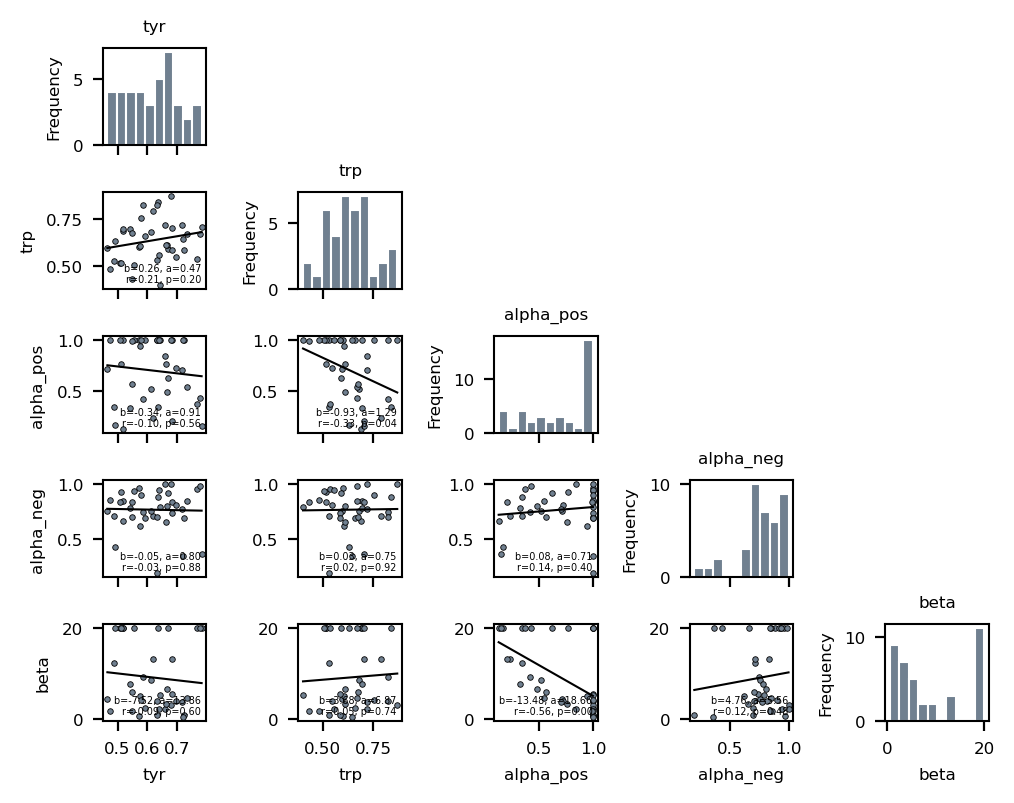

In [50]:
pairplot(df[["tyr", "trp", "alpha_pos", "alpha_neg", "beta"]].dropna());

## Correlation of learning rates and physiological measures, within each condition

'highcarb' condition
trp ~ tyr
  b=0.48, a=0.41, r=0.39, p=0.10, n.s.

alpha_pos ~ tyr
  b=0.53, a=0.34, r=0.13, p=0.59, n.s.

alpha_pos ~ trp
  b=-0.26, a=0.84, r=-0.08, p=0.75, n.s.

alpha_neg ~ tyr
  b=0.50, a=0.50, r=0.30, p=0.22, n.s.

alpha_neg ~ trp
  b=0.31, a=0.58, r=0.23, p=0.35, n.s.

alpha_neg ~ alpha_pos
  b=0.21, a=0.65, r=0.51, p=0.02*

beta ~ tyr
  b=-25.68, a=23.55, r=-0.30, p=0.21, n.s.

beta ~ trp
  b=14.56, a=-1.84, r=0.21, p=0.40, n.s.

beta ~ alpha_pos
  b=-14.20, a=17.57, r=-0.67, p=0.00*

beta ~ alpha_neg
  b=-21.17, a=25.09, r=-0.41, p=0.08, n.s.



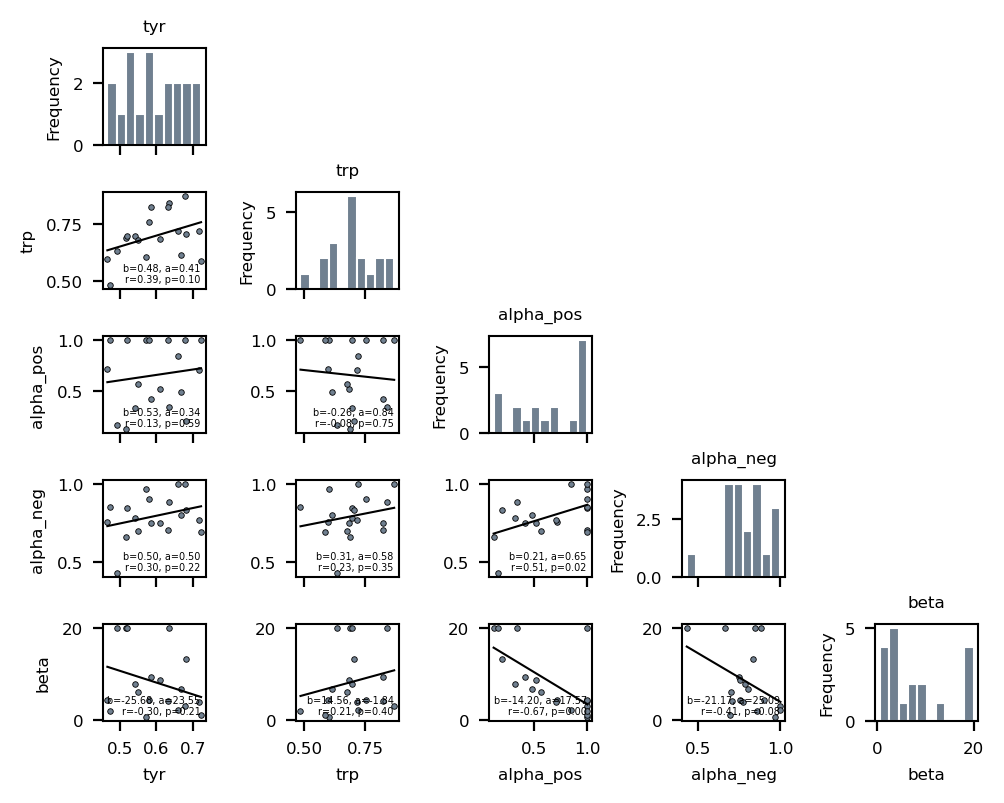

'highpro' condition
trp ~ tyr
  b=0.46, a=0.28, r=0.45, p=0.05*

alpha_pos ~ tyr
  b=-1.30, a=1.58, r=-0.39, p=0.09, n.s.

alpha_pos ~ trp
  b=-1.75, a=1.76, r=-0.54, p=0.01*

alpha_neg ~ tyr
  b=-0.33, a=0.95, r=-0.13, p=0.57, n.s.

alpha_neg ~ trp
  b=-0.61, a=1.10, r=-0.26, p=0.28, n.s.

alpha_neg ~ alpha_pos
  b=-0.04, a=0.77, r=-0.05, p=0.84, n.s.

beta ~ tyr
  b=0.12, a=10.02, r=0.00, p=1.00, n.s.

beta ~ trp
  b=7.31, a=5.85, r=0.08, p=0.73, n.s.

beta ~ alpha_pos
  b=-14.24, a=20.70, r=-0.53, p=0.02*

beta ~ alpha_neg
  b=15.04, a=-1.05, r=0.41, p=0.07, n.s.



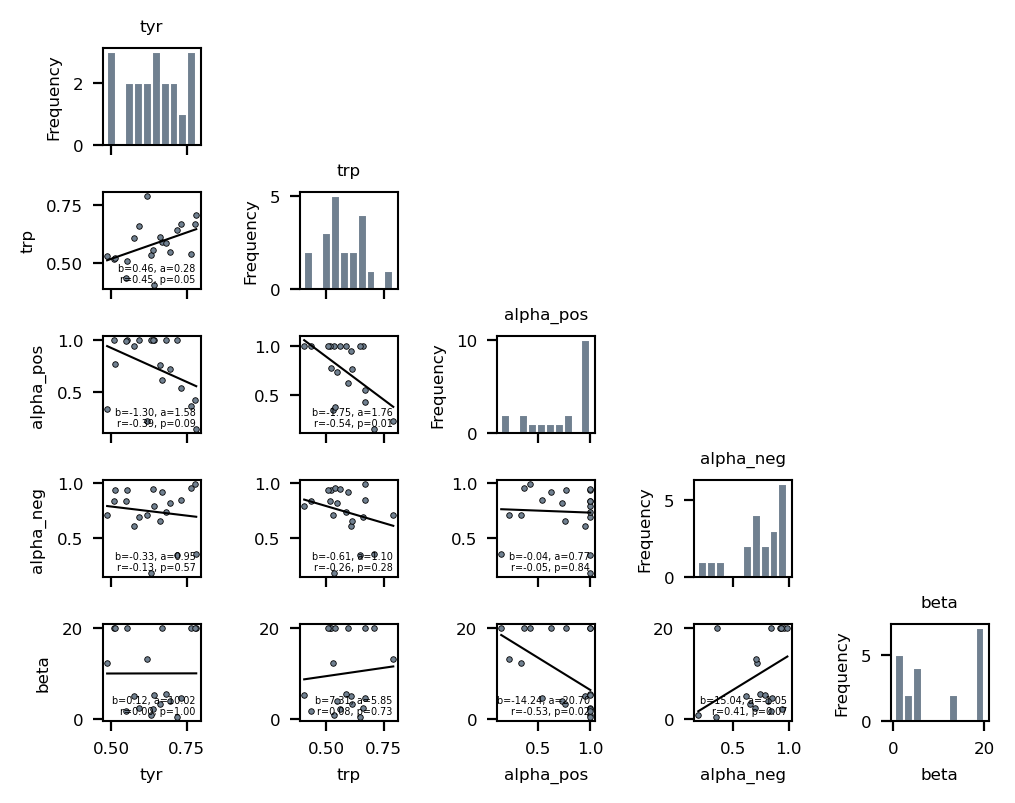

In [52]:
for condition in ["highcarb", "highpro"]:
    print(f"'{condition}' condition")
    df_c = df.loc[df["condition"] == condition]
    pairplot(df_c[["tyr", "trp", "alpha_pos", "alpha_neg", "beta"]].dropna())
    plt.show()

## Correlation of change in physiological measures and change in learning rates

In [53]:
# Make wide dataframe with differences between conditions
df_wide = df.pivot(
    index="subject",
    columns="condition",
    values=["tyr", "trp", "alpha_pos", "alpha_neg"],
).reset_index()

# compute differences
for var in ["tyr", "trp", "alpha_pos", "alpha_neg"]:
    df_wide[(f"d_{var}")] = df_wide[(var, "highcarb")] - df_wide[(var, "highpro")]

df_wide = df_wide[["subject", "d_tyr", "d_trp", "d_alpha_pos", "d_alpha_neg"]]

# Remove multiindex
df_wide.columns = df_wide.columns.droplevel(1)

df_wide.head()

,subject,d_tyr,d_trp,d_alpha_pos,d_alpha_neg
0,1,0.031,0.159,-0.214084,-0.050266
1,2,0.042,0.180,-0.658015,0.189050
2,3,-0.032,0.032,0.188648,0.038945
3,4,-0.060,0.072,0.000000,0.778597
4,5,0.010,0.180,0.000000,0.005254


d_trp ~ d_tyr
  b=0.53, a=0.13, r=0.50, p=0.03*

d_alpha_pos ~ d_tyr
  b=-1.61, a=-0.16, r=-0.43, p=0.06, n.s.

d_alpha_pos ~ d_trp
  b=-0.27, a=-0.06, r=-0.08, p=0.75, n.s.

d_alpha_neg ~ d_tyr
  b=-0.00, a=0.06, r=-0.00, p=1.00, n.s.

d_alpha_neg ~ d_trp
  b=-0.77, a=0.14, r=-0.30, p=0.21, n.s.

d_alpha_neg ~ d_alpha_pos
  b=0.05, a=0.06, r=0.06, p=0.79, n.s.



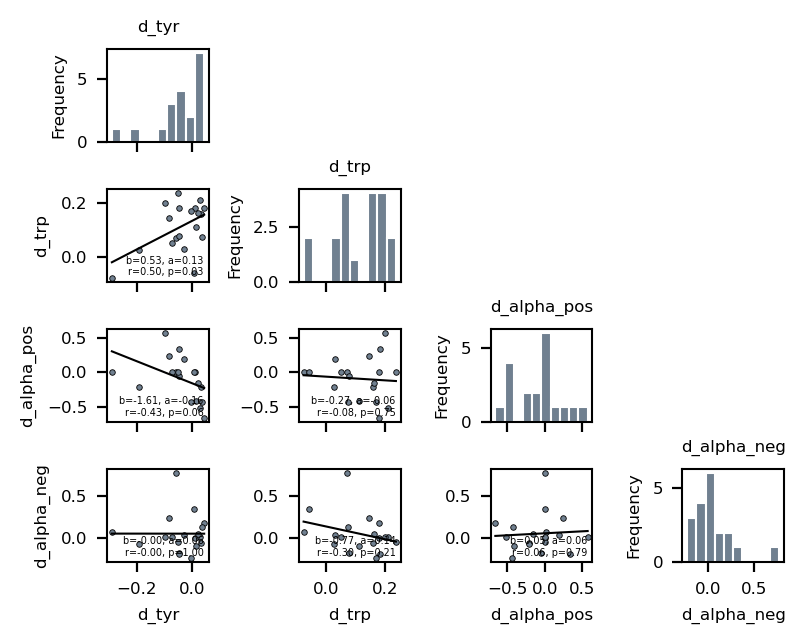

In [54]:
pairplot(df_wide[["d_tyr", "d_trp", "d_alpha_pos", "d_alpha_neg"]].dropna());